In [1]:
from PIL import Image as PILImage
from img2table.document import Image
from img2table.ocr import TesseractOCR
from img2table.tables.processing.common import get_contours_cell, is_contained_cell, merge_contours
from img2table.tables.processing.lines import detect_lines
from img2table.tables.objects.cell import Cell
from colordict import ColorDict
import cv2
import numpy as np

In [2]:
import random
colors = ColorDict()

def get_color():
    idx = random.randint(0, len(colors) - 1)
    return list(colors.values())[idx]

### Loading image

In [3]:
img = Image(r"C:\Users\xavca\Pictures\test_2.png")
ocr = TesseractOCR()
ocr_df = ocr.of(img)
dpi = 200

img = list(img.images)[0]

### Remove lines

In [4]:
h_lines, v_lines = detect_lines(image=img,
                                rho=0.3,
                                theta=np.pi / 180,
                                threshold=10,
                                minLinLength=dpi // 20,
                                maxLineGap=dpi // 20,
                                kernel_size=dpi // 10,
                                ocr_df=ocr_df)
lines = h_lines + v_lines

img_no_lines = img.copy()
for line in lines:
    cv2.rectangle(img_no_lines, (line.x1, line.y1), (line.x2, line.y2), (255, 255, 255), 5)

### Remove dark bg

In [5]:
blur = cv2.GaussianBlur(img_no_lines, (3, 3), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
dilation = cv2.dilate(thresh, (10, 10), iterations=3)
contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = Cell(x1=0, x2=0, y1=0, y2=0)
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    contour_cell = Cell(x, y, x + w, y + h)
    
    if contour_cell.width * contour_cell.height > largest_contour.width * largest_contour.height:
        largest_contour = contour_cell
        
# Recreate image
white_img = np.zeros(img.shape, dtype=np.uint8)
white_img.fill(255)

# Add contour from original image
cropped_img = img_no_lines[largest_contour.y1:largest_contour.y2, largest_contour.x1:largest_contour.x2]
white_img[largest_contour.y1:largest_contour.y2, largest_contour.x1:largest_contour.x2] = cropped_img

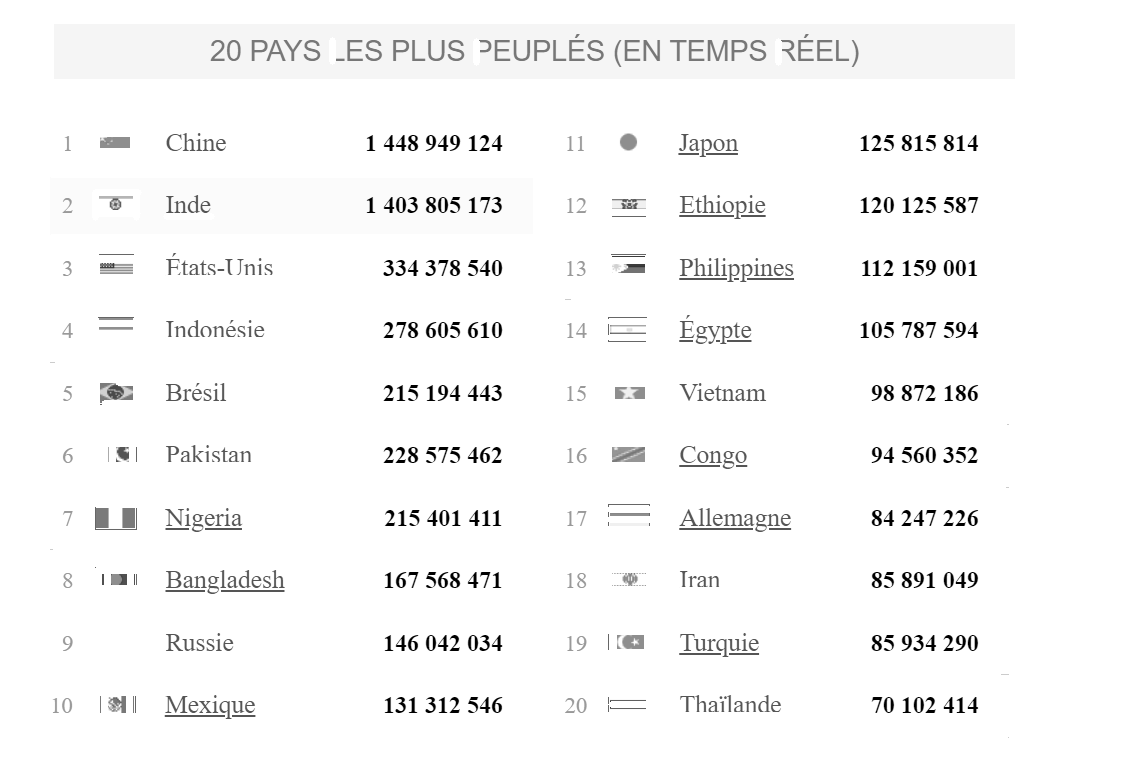

In [6]:
PILImage.fromarray(white_img)

### Image segmentation

In [7]:
img_segments = get_contours_cell(img=white_img.copy(),
                                 cell=Cell(x1=0, y1=0, x2=img.shape[1], y2=img.shape[0]),
                                 margin=0,
                                 blur_size=3,
                                 kernel_size=dpi // 10,
                                 merge_vertically=True)

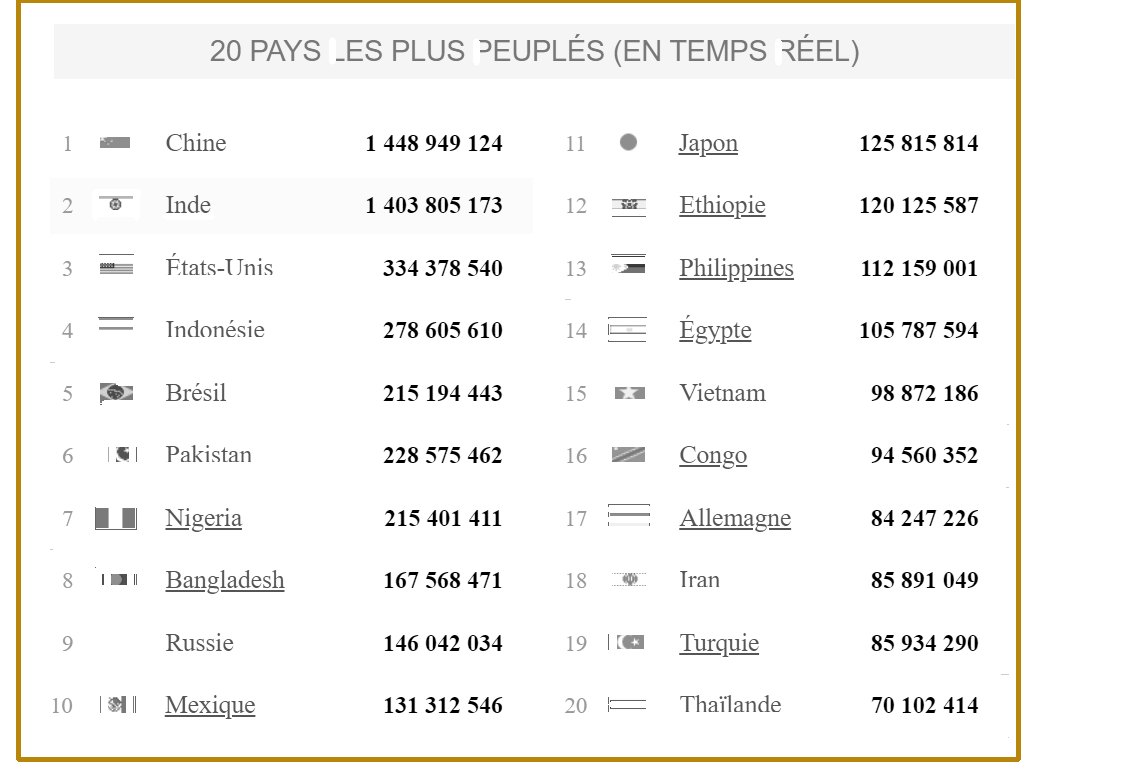

In [8]:
display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

for cnt in img_segments:
    cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

### Text segmentation

In [9]:
text_contours = get_contours_cell(img=white_img.copy(),
                                  cell=Cell(x1=0, y1=0, x2=img.shape[1], y2=img.shape[0]),
                                  margin=0,
                                  blur_size=3,
                                  kernel_size=dpi * 3 // 200,
                                  merge_vertically=None)

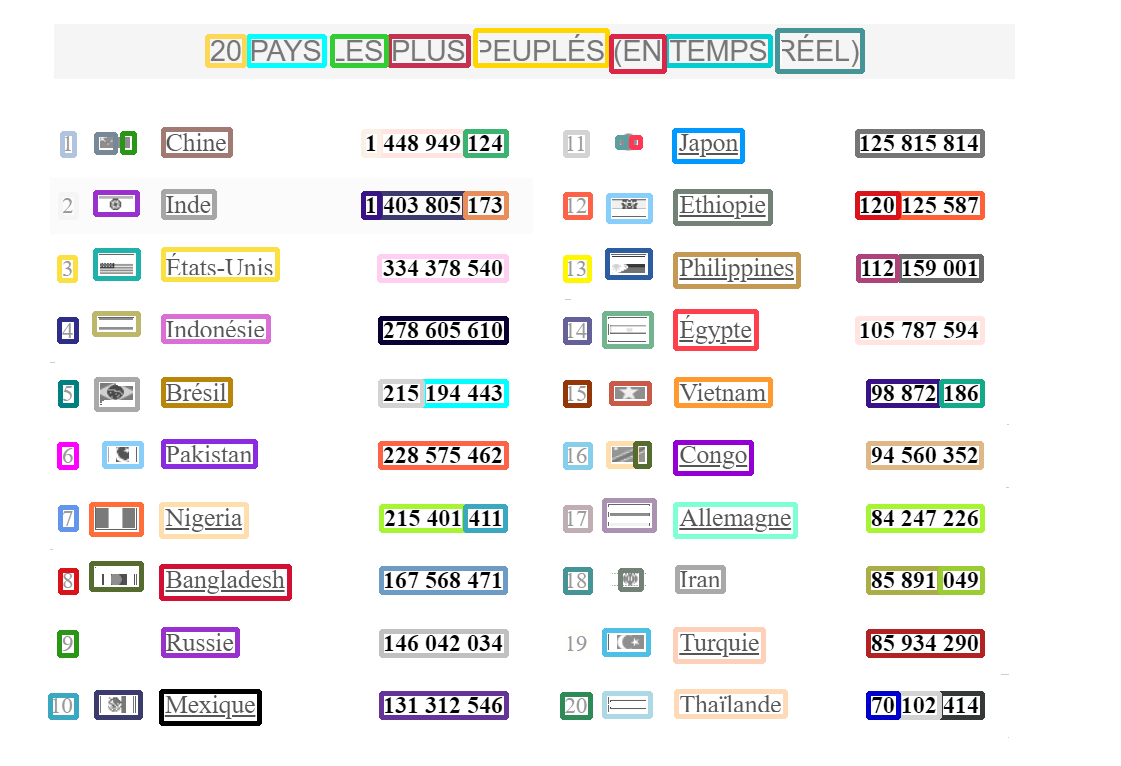

In [10]:
display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

for cnt in text_contours:
    cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

### Assign text contours to specific segments

In [11]:
dict_segments = {seg: [] for seg in img_segments}
for cnt in text_contours:
    # Find most likely segment
    best_segment = sorted([seg for seg in img_segments if is_contained_cell(inner_cell=cnt, outer_cell=seg)],
                          key=lambda s: s.width * s.height,
                          reverse=True).pop(0)
    dict_segments[best_segment].append(cnt)

### Manual clustering

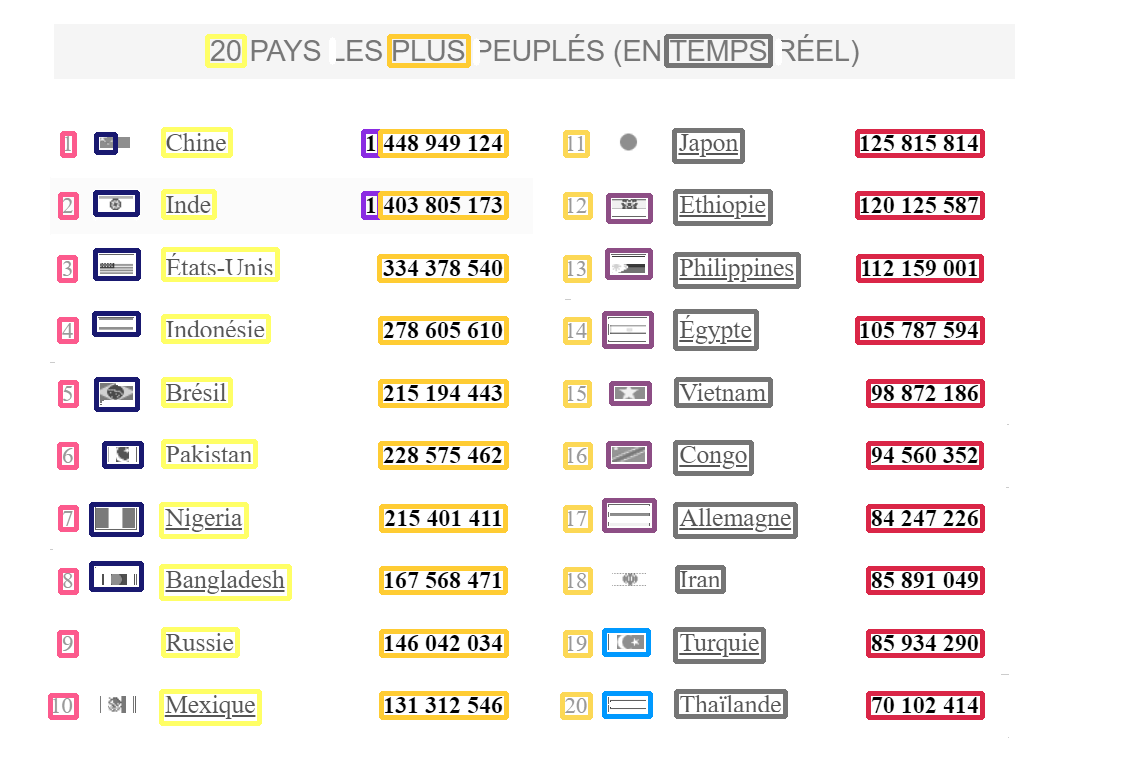

In [12]:
from img2table.tables.processing.borderless_tables.cluster_text import cluster_text_contours

display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)


segments_clusters = [cluster_text_contours(segment) for segment in dict_segments.values()]

for seg_clust in segments_clusters:
    for clust in seg_clust:
        color = get_color()
        for cnt in clust:
            cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), color, 3)

PILImage.fromarray(display_img)

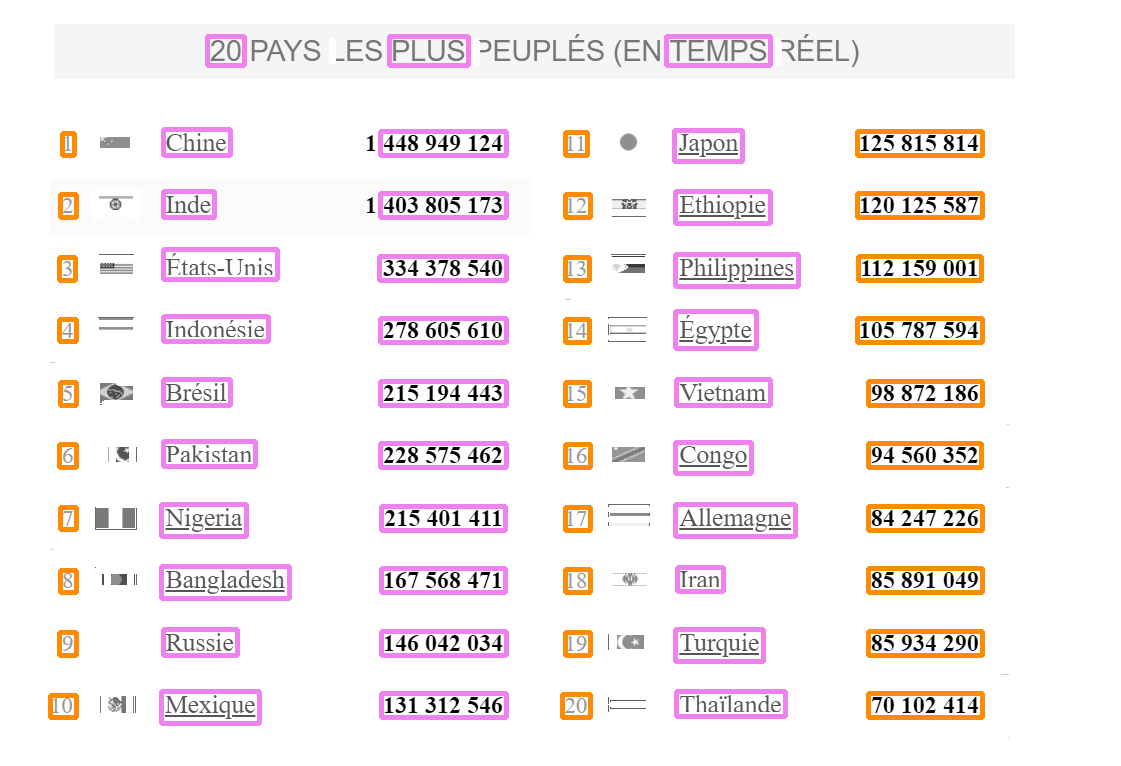

In [13]:
from itertools import combinations

display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

def find_common_rows(cluster_1, cluster_2):
    # Compute cluster height
    nb_rows = max(len(cluster_1), len(cluster_2))
    height = max([c.y2 for c in cluster_1 + cluster_2]) - min([c.y1 for c in cluster_1 + cluster_2])
    
    nb_common_rows = 0
    for cell in cluster_1:
        # Get corresponding cells in cluster 2
        corresponding_cells = [(cell, c) for c in cluster_2
                               if abs(c.y1 + c.y2 - cell.y1 - cell.y2) / (2 * height) <= 1 / (4 * nb_rows)]
        if corresponding_cells:
            nb_common_rows += 1
    
    return nb_common_rows

def dfs(graph, start, end):
    fringe = [(start, [])]
    while fringe:
        state, path = fringe.pop()
        if path and state == end:
            yield path
            continue
        for next_state in graph[state]:
            if next_state in path:
                continue
            fringe.append((next_state, path+[next_state]))

for clusters in segments_clusters:
    d_common_rows = {(idx1, idx2): find_common_rows(clusters[idx1], clusters[idx2])
                     for idx1, idx2 in list(combinations(range(len(clusters)), 2))
                    }

    d_links = dict()
    for idx in range(len(clusters)):
        # Filter on links with the relevant clusters
        d_common_rows_cluster = {k: v for k, v in d_common_rows.items() if v > 1 and idx in k}
        # Get best links 
        best_links = [k for k, v in d_common_rows_cluster.items() if v == max(d_common_rows_cluster.values())]

        for link in map(list, best_links):
            link.remove(idx)
            d_links[idx] = d_links.get(idx, []) + link
            
    cycles = [path for node in d_links for path in dfs(d_links, node, node)]

    # Get maximal cycles
    seq = iter(sorted(cycles, key=lambda cc: len(cc), reverse=True))
    final_cycles = [set(next(seq))]
    for cycle in seq:
        c_set = set(cycle)
        if not any([c_set.intersection(c) == c_set for c in final_cycles]):
            final_cycles.append(c_set)
            
    final_cycles = [[clusters[idx] for idx in cycle] for cycle in final_cycles]
    
    for cycle in final_cycles:
        color = get_color()
        for clust in cycle:
            for cnt in clust:
                cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), color, 3)

PILImage.fromarray(display_img)